# Measure preformance of insertion 
- using fragment ID as primary key
- try changing synchronous to normal

**Set environment**

In [1]:
from prep_insert import *

In [2]:
#######################################################
### parse arguments
###++++++++++++++++++++++++++++++++++++++++++++++++++++
CHROM   = "chr17"                          #args.chrom
FD_OUT  = os.path.join(FD_RES, "database") #args.fout
FD_INP  = os.path.join(FD_RES, "nuc")      #args.finp
PREFIX  = "test_insert"                    #args.prefix
SUFFIX  = "fragid_sync_norm"
VERBOSE = True                             #args.verbose

#######################################################
### Set global varialbes and I/O
###++++++++++++++++++++++++++++++++++++++++++++++++++++

### file path of fragment database
fdiry  = FD_OUT
fname  = f"{PREFIX}_{CHROM}_{SUFFIX}.db"
FP_DTB = os.path.join(fdiry, fname)

### file path of fragment table
sample  = "Input1_20x"
fdiry   = os.path.join(FD_INP, sample)
fname   = "chr17.bed.gz"
FP_FRG  = os.path.join(fdiry, fname)

### show info
if (VERBOSE):
    print("Global variables:")
    print("Chromsome:  ", CHROM)
    print("Database:   ", FP_DTB)
    print("Input file: ", FP_FRG)
    print()

Global variables:
Chromsome:   chr17
Database:    /gpfs/fs1/data/reddylab/Kuei/out/proj_combeffect/database/test_insert_chr17_fragid_sync_norm.db
Input file:  /gpfs/fs1/data/reddylab/Kuei/out/proj_combeffect/nuc/Input1_20x/chr17.bed.gz



## Set database function for insertion

In [3]:
def insert_line_by_line(n_lines, query_table, fpath_database, fpath_table):
    """Helper function to insert rows into table line by line"""
    
    ### init a new table
    refresh(query_table, fpath_database)
    
    with sqlite3.connect(fpath_database) as conn:
        ### initiation
        cursor = conn.cursor()
        
        ### read file
        with gzip.open(fpath_table, "rb") as file:
            
            ### generate lines
            lines = gen_line(file, n_lines=n_lines)

            ### insert line by line
            for line in lines:
                cursor.execute(query_insert, line)
                
def insert_line_by_chunk(n_lines, n_chunksize, query_table, fpath_database, fpath_table):
    """Helper function to insert rows into table by chunk"""
    ### init a new table
    refresh(query_table, fpath_database)
    
    with sqlite3.connect(fpath_database) as conn:
        ### initiation
        cursor = conn.cursor()
        cursor = cursor.execute("PRAGMA synchronous = normal")
        ### read file
        with gzip.open(fpath_table, "rb") as file:
            
            ### generate chunks
            chunks = gen_line(file, n_chunksize=n_chunksize, n_lines=n_lines)
            
            ### insert chunk by chunk
            for chunk in chunks:
                cursor.executemany(query_insert, chunk)

## Measure performance

In [4]:
%%time
time.sleep(2)

CPU times: user 1.56 ms, sys: 835 µs, total: 2.4 ms
Wall time: 2 s


**Initialization**

In [5]:
N = 1
R = 2

n_lines     = [10, 100, 1000, 5000, 10000, 50000, 100000]
n_chunksize = [1, 10, 100, 1000]

fpath_database = FP_DTB
fpath_table    = FP_FRG
query_table    = query_table_frag

**Measure time for insert line by line**

In [6]:
%%time
res = list()

for n in n_lines:
    fun = lambda: insert_line_by_line(n, query_table, fpath_database, fpath_table)
    lst = timeit.repeat(fun, number=N, repeat=R)
    res.append(np.min(lst))   
    
res_line = res

CPU times: user 3.43 s, sys: 340 ms, total: 3.77 s
Wall time: 4.42 s


**Measure time for insert line by chunk**

In [7]:
%%time
mat = list()

for c in n_chunksize:
    res = list()
    for n in n_lines:
        print(f"#Lines: {n}; #Chunksize: {c}")
        fun = lambda: insert_line_by_chunk(n, c, query_table, fpath_database, fpath_table)
        lst = timeit.repeat(fun, number=N, repeat=R)
        res.append(np.min(lst))
    mat.append(res)
    
mat_chunk = mat

#Lines: 10; #Chunksize: 1
#Lines: 100; #Chunksize: 1
#Lines: 1000; #Chunksize: 1
#Lines: 5000; #Chunksize: 1
#Lines: 10000; #Chunksize: 1
#Lines: 50000; #Chunksize: 1
#Lines: 100000; #Chunksize: 1
#Lines: 10; #Chunksize: 10
#Lines: 100; #Chunksize: 10
#Lines: 1000; #Chunksize: 10
#Lines: 5000; #Chunksize: 10
#Lines: 10000; #Chunksize: 10
#Lines: 50000; #Chunksize: 10
#Lines: 100000; #Chunksize: 10
#Lines: 10; #Chunksize: 100
#Lines: 100; #Chunksize: 100
#Lines: 1000; #Chunksize: 100
#Lines: 5000; #Chunksize: 100
#Lines: 10000; #Chunksize: 100
#Lines: 50000; #Chunksize: 100
#Lines: 100000; #Chunksize: 100
#Lines: 10; #Chunksize: 1000
#Lines: 100; #Chunksize: 1000
#Lines: 1000; #Chunksize: 1000
#Lines: 5000; #Chunksize: 1000
#Lines: 10000; #Chunksize: 1000
#Lines: 50000; #Chunksize: 1000
#Lines: 100000; #Chunksize: 1000
CPU times: user 12.2 s, sys: 1.54 s, total: 13.7 s
Wall time: 20.9 s


**Results visualization**

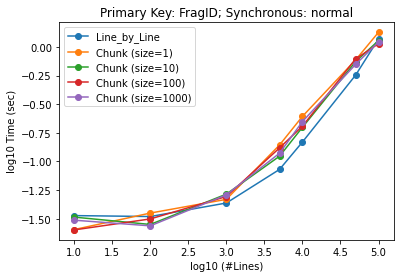

In [8]:
### results
results = [res_line] + mat_chunk

### labels for each result
fun = np.core.defchararray.add
idx = np.array(n_chunksize).astype("str")

labels = reduce(fun, ["Chunk (size=", idx, ")"])
labels = np.r_[["Line_by_Line"], labels]

### plot the time vs number lines insert into the database
for res, lab in zip(results, labels):
    plt.plot(np.log10(n_lines), np.log10(res), "-o", label=lab)
plt.legend()
plt.xlabel("log10 (#Lines)")
plt.ylabel("log10 Time (sec)")
plt.title("Primary Key: FragID; Synchronous: normal")
plt.show()